In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from fuzzywuzzy import fuzz
import os
import glob
import matplotlib.pyplot as plt

In [6]:
#fazer o uplod diretamente pelos arquivos
from google.colab import files

arquivo = files.upload()

Saving us-shein-appliances-3987.csv to us-shein-appliances-3987.csv


In [15]:
df = pd.read_csv('us-shein-appliances-3987.csv')

In [16]:
file_to_process = csv_files[0]  # Escolha o primeiro arquivo como exemplo
df = pd.read_csv(file_to_process)

In [29]:
def explore_data(df):
  print(f"Analisando o arquivo: {file_to_process}")

In [31]:
print("\nInformações do dataset:")
print(df.info())


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   goods-title-link--jump       40 non-null     object
 1   goods-title-link--jump href  40 non-null     object
 2   rank-title                   559 non-null    object
 3   rank-sub                     559 non-null    object
 4   price                        3986 non-null   object
 5   discount                     2459 non-null   object
 6   selling_proposition          1361 non-null   object
 7   goods-title-link             3946 non-null   object
dtypes: object(8)
memory usage: 249.3+ KB
None


In [32]:
print("\nEstatísticas descritivas:")
print(df.describe())



Estatísticas descritivas:
                                   goods-title-link--jump  \
count                                                  40   
unique                                                 40   
top     1pc Rechargeable Deep Tissue Muscle Handheld M...   
freq                                                    1   

                              goods-title-link--jump href       rank-title  \
count                                                  40              559   
unique                                                 40               10   
top     https://us.shein.com/1pc-Rechargeable-Deep-Tis...  #4 Best Sellers   
freq                                                    1               63   

              rank-sub  price discount selling_proposition  \
count              559   3986     2459                1361   
unique             124   1512       80                  64   
top     in Hair Dryers  $2.90     -28%   10+ sold recently   
freq                14     3

In [33]:
print("\nValores ausentes por coluna:")
print(df.isnull().sum())



Valores ausentes por coluna:
goods-title-link--jump         3946
goods-title-link--jump href    3946
rank-title                     3427
rank-sub                       3427
price                             0
discount                       1527
selling_proposition            2625
goods-title-link                 40
dtype: int64


In [34]:
print("\nPorcentagem de valores ausentes por coluna:")
print(df.isnull().mean() * 100)



Porcentagem de valores ausentes por coluna:
goods-title-link--jump         98.996488
goods-title-link--jump href    98.996488
rank-title                     85.975916
rank-sub                       85.975916
price                           0.000000
discount                       38.309082
selling_proposition            65.855494
goods-title-link                1.003512
dtype: float64


In [35]:
print("\nDuplicatas:")
print(df.duplicated().sum())


Duplicatas:
209


In [38]:
# Visualização do missing %
plt.figure(figsize=(10,5))
missing_df.head(20)['missing_percent'].plot(kind='bar', color='orange')
plt.title('Porcentagem de valores ausentes por coluna')
plt.ylabel('% missing')
plt.show()

NameError: name 'missing_df' is not defined

<Figure size 1000x500 with 0 Axes>

In [40]:
# Remover duplicadas exatas
dup_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"\nDuplicadas removidas: {dup_count}")


Duplicadas removidas: 209


In [42]:
# Remover colunas com mais de 70% missing
cols_to_drop = missing_df[missing_df['missing_percent'] > 70]['column_name'].tolist()
df = df.drop(columns=cols_to_drop)
print(f"Colunas removidas por alta ausência: {cols_to_drop}")

Colunas removidas por alta ausência: ['goods-title-link--jump', 'goods-title-link--jump href', 'rank-title', 'rank-sub']


In [43]:
# Padronizar textos
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.lower()

print("\nPadronização de texto concluída.")


Padronização de texto concluída.


In [44]:
# Converter preço (remover símbolos e converter para float)
if 'price' in df.columns:
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2337731760.py:3: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


In [45]:
# Imputação simples
for col in df.columns:
    if df[col].dtype == 'float' or df[col].dtype == 'int':
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

print("Valores ausentes tratados.")

Valores ausentes tratados.


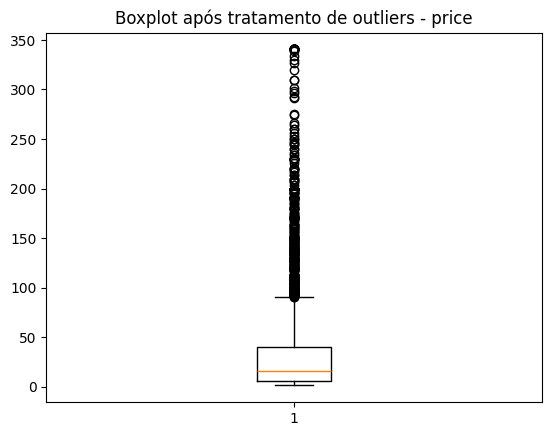

Outliers tratados via capping (1º e 99º percentil).


In [46]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], q1, q99)

    plt.figure()
    plt.boxplot(df[col])
    plt.title(f'Boxplot após tratamento de outliers - {col}')
    plt.show()

print("Outliers tratados via capping (1º e 99º percentil).")

In [ ]:
#Novas features
# Exemplo: comprimento do título do produto
if 'goods-title-link' in df.columns:
    df['title_length'] = df['goods-title-link'].astype(str).apply(len)

# Exemplo: conversão de desconto para número
if 'discount' in df.columns:
    df['discount_pct'] = df['discount'].str.replace('%','').str.replace('-','').astype(float)

print("Novas features criadas.")

In [47]:
#Avaliação de qualidade
print("\n--- Resumo Final ---")
print(f"Shape final: {df.shape}")
print(f"Duplicadas restantes: {df.duplicated().sum()}")
print("\nValores ausentes após limpeza:")
print(df.isnull().sum())


--- Resumo Final ---
Shape final: (3777, 4)
Duplicadas restantes: 5

Valores ausentes após limpeza:
price                  0
discount               0
selling_proposition    0
goods-title-link       0
dtype: int64


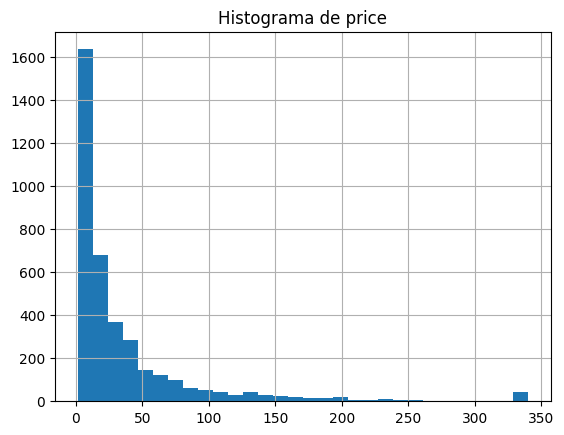

In [48]:
# Histograma de colunas numéricas
for col in numeric_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Histograma de {col}')
    plt.show()